# CSI 4106 Introduction to Artificial Intelligence 
## Assignment 2: Machine Learning

## Report Title: Data Preparation, Model Development and Parameter Optimization for Machine Learning

### Identification

Name: Alex Govier <br/>
Student Number: 300174954

#### Import Necessary Libraries

In [252]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score, make_scorer
from sklearn.metrics import classification_report

### Exploratory Analysis

#### 1. Loading Dataset and Summary

In [253]:
# Loading the diabetes dataset from my GitHub
diabetes_url = "https://github.com/alex-govier5/intro-to-ai/raw/master/A2/diabetes_prediction_dataset.csv"
dataset = pd.read_csv(diabetes_url)

print(dataset.head(5))

   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0  


This is a large dataset of around 100,000 rows containing patient's medical information. It has their gender which is categorical, it has their age which is numerical, it has hypertension which is categorical in binary indicating whether the patient has hypertension or not, it has heart_disease which is also categorical and binary indicating if the patient has heart disease or not, it has smoking_history which is categorical indicating they're smoking habits, it has bmi which is numerical indicating the patient's body mass index, it has the HbA1c_level, indicating the patient's Hemoglobin A1c level, it has the bloode_glucose_level which is numerical, indicating the patient's blood sugar level, and then finally it has diabetes which is the target variable which is categorical and binary, indicating whether the patient has diabetes or not (0 = No, 1 = Yes).

#### 2. Feature Distribution Analysis
Here I will visualize all of my attributes and then provide an analysis.

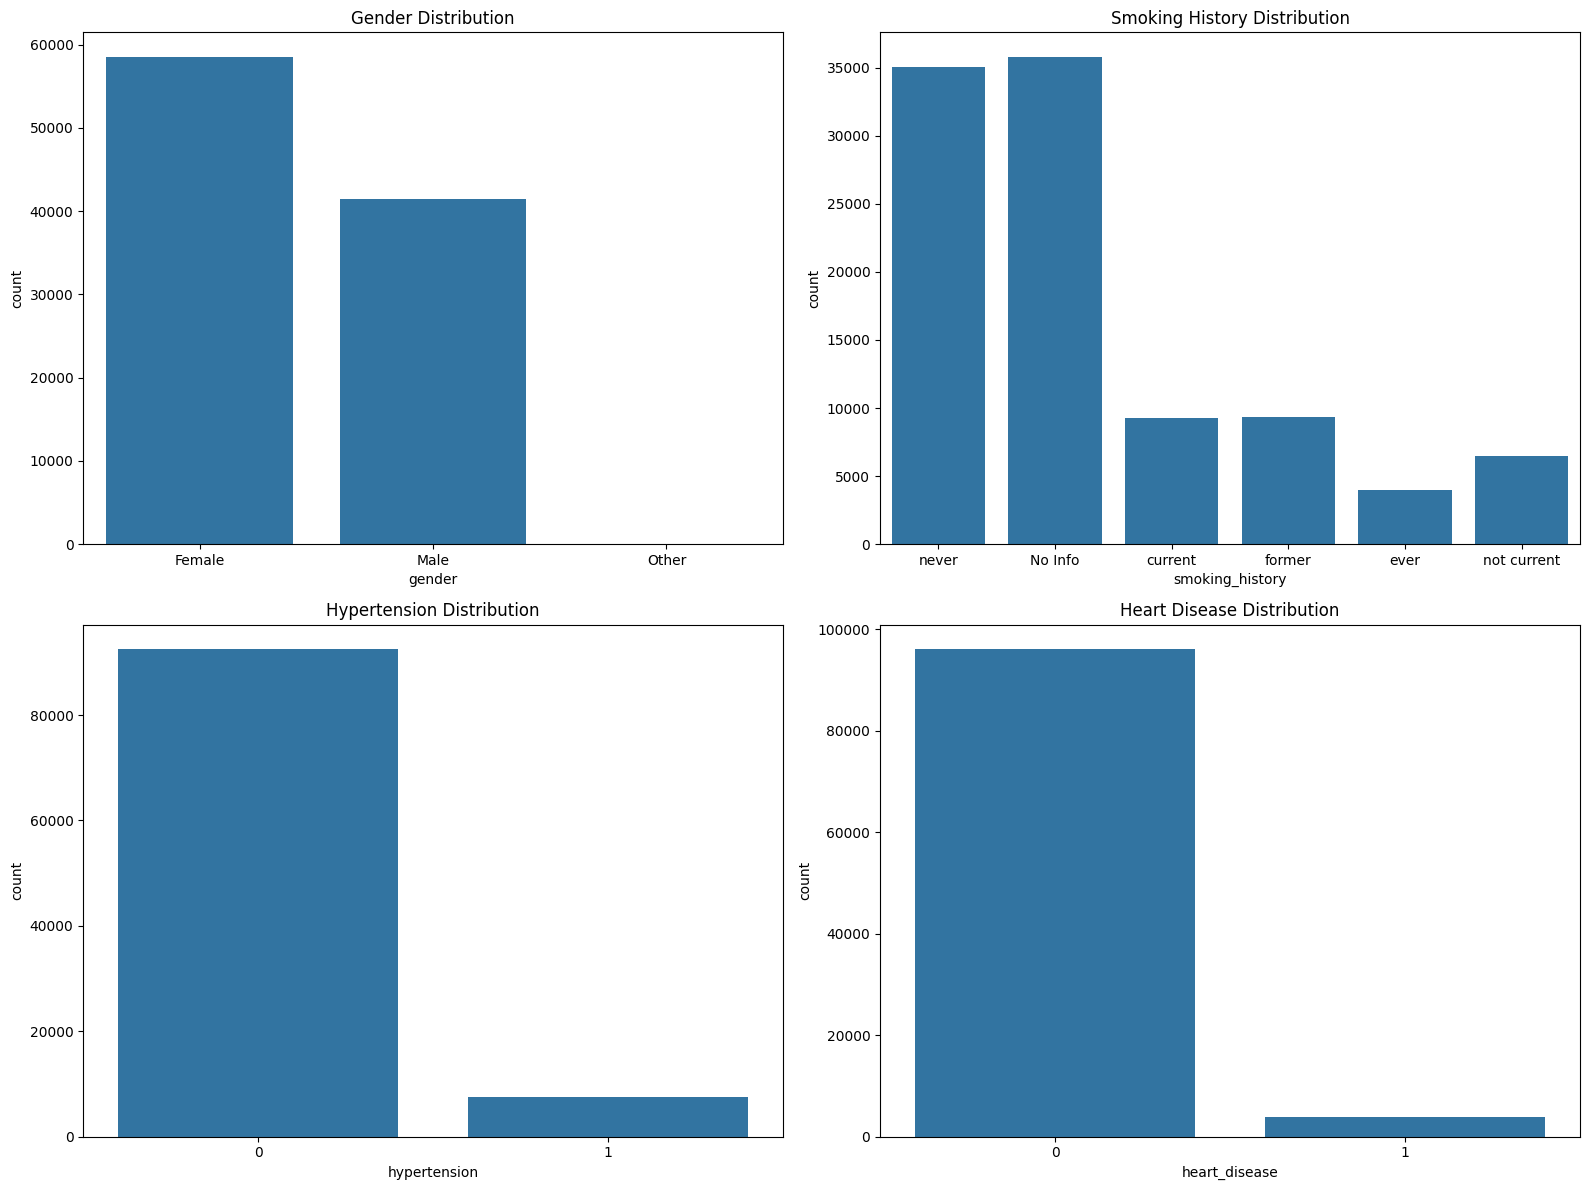

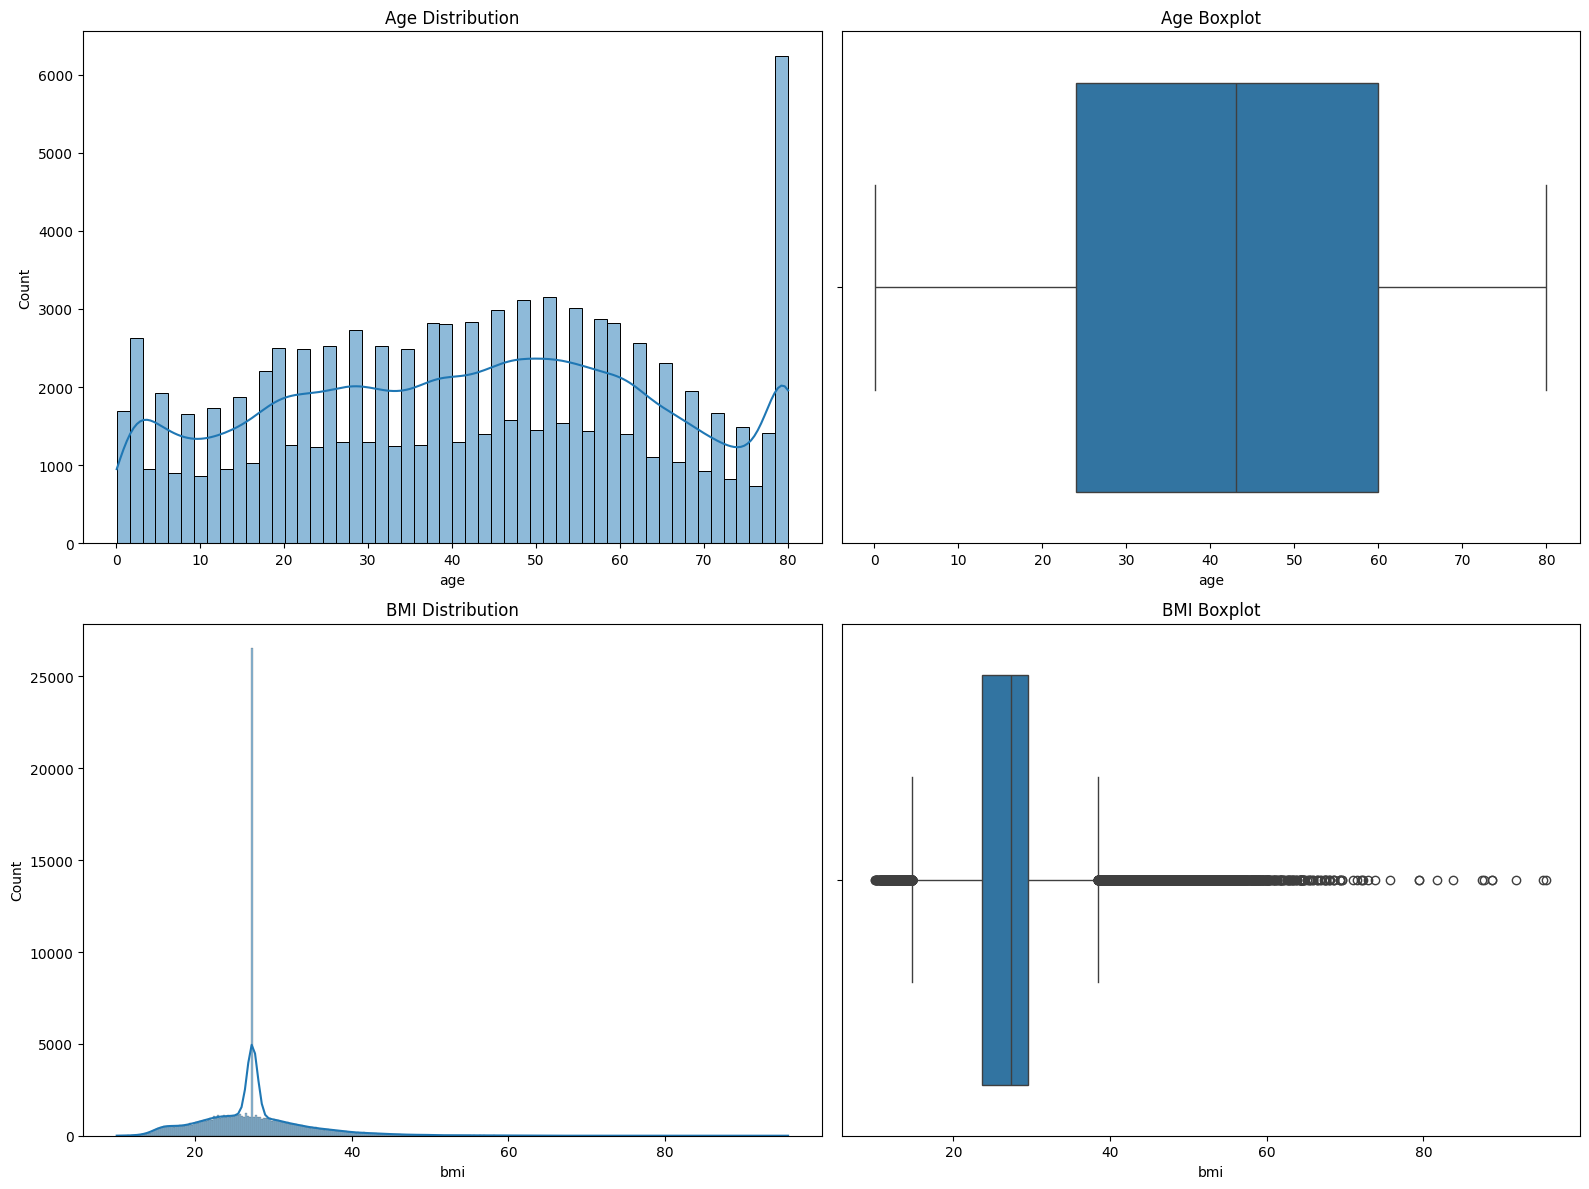

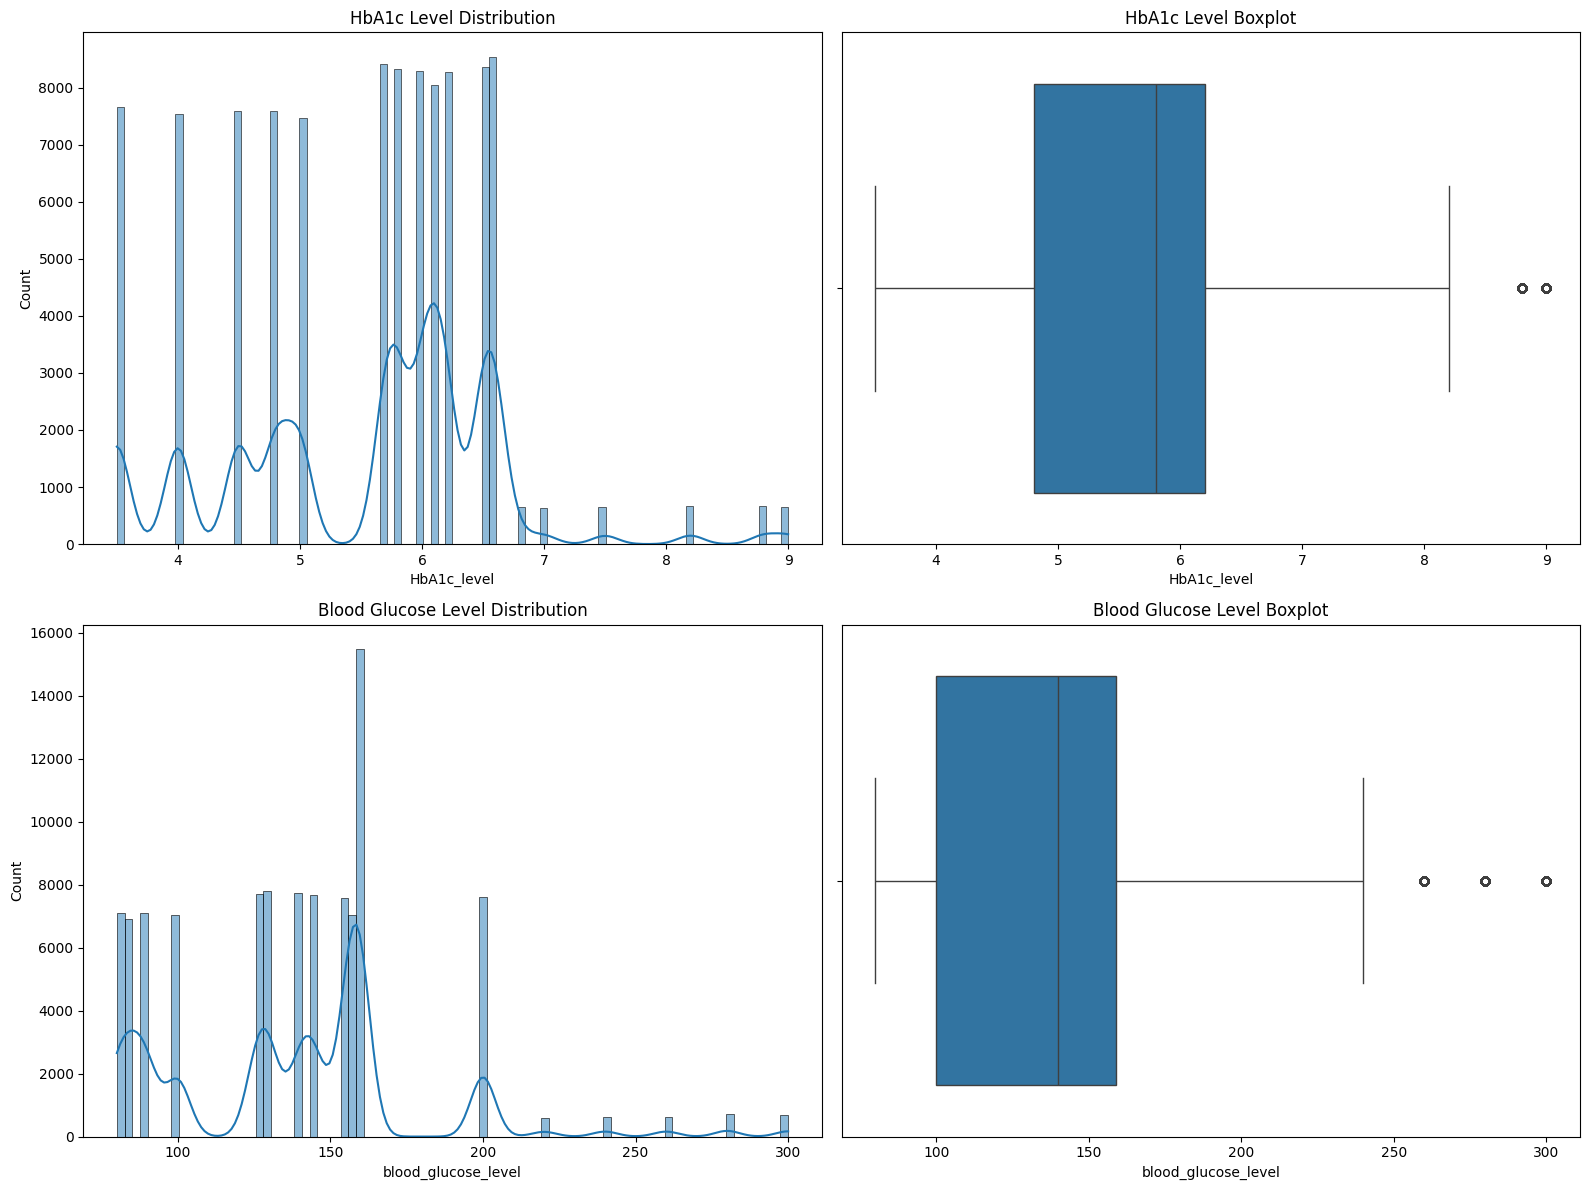

In [254]:
# Convert the dataset to a dataframe
df = pd.DataFrame(dataset)

# Will separate visualizations by type, so countplots for categorical attributes
plt.figure(figsize=(16, 12))

# Gender
plt.subplot(2, 2, 1)
sns.countplot(x='gender', data=df)
plt.title('Gender Distribution')

# Smoking history
plt.subplot(2, 2, 2)
sns.countplot(x='smoking_history', data=df)
plt.title('Smoking History Distribution')

# Hypertension
plt.subplot(2, 2, 3)
sns.countplot(x='hypertension', data=df)
plt.title('Hypertension Distribution')

# Heart disease
plt.subplot(2, 2, 4)
sns.countplot(x='heart_disease', data=df)
plt.title('Heart Disease Distribution')

plt.tight_layout()
plt.show()

# Histograms and boxplots for numerical attributes

plt.figure(figsize=(16, 12))

# Age
plt.subplot(2, 2, 1)
sns.histplot(df['age'], kde=True)
plt.title('Age Distribution')

plt.subplot(2, 2, 2)
sns.boxplot(x=df['age'])
plt.title('Age Boxplot')

# BMI 
plt.subplot(2, 2, 3)
sns.histplot(df['bmi'], kde=True)
plt.title('BMI Distribution')

plt.subplot(2, 2, 4)
sns.boxplot(x=df['bmi'])
plt.title('BMI Boxplot')

plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 12))

# HbA1c
plt.subplot(2, 2, 1)
sns.histplot(df['HbA1c_level'], kde=True)
plt.title('HbA1c Level Distribution')

plt.subplot(2, 2, 2)
sns.boxplot(x=df['HbA1c_level'])
plt.title('HbA1c Level Boxplot')

# Blood glucose
plt.subplot(2, 2, 3)
sns.histplot(df['blood_glucose_level'], kde=True)
plt.title('Blood Glucose Level Distribution')

plt.subplot(2, 2, 4)
sns.boxplot(x=df['blood_glucose_level'])
plt.title('Blood Glucose Level Boxplot')

plt.tight_layout()
plt.show()


For gender, the dataset may be skewed towards females, which could affect the model, the Other category appears to be negligible in this case. <br/>
For smoking history, the high count of No Info means there is a lot of missing data here, this may affect meaningful analysis, and current smokers are less represented than never smokers, so this could affect the model as well.<br/> 
For hypertension, majority of patients don't have hypertension, this imbalance could affect the model training to make it a bit biased, the same can be said with heart disease, vast majority don't have heart disease so the same problem could arise. <br/>
The age attribute is well distributed with a large spike in patients over 80 which makes sense in this case, there doesn't seem to be any significant outliers here. <br/>
The BMI distribution is highly skewed with a large peak around a specific value around 20, so most individuals in the dataset have a BMI close to the median or mean, however there are a lot of outliers here at the upper end so a few people have a quite high BMI. <br/>
The HbA1c distribution is uneven, with indicators of binning, so it might not have been continuous but rather in intervals, there are a few outliers which means some people have a significantly higher Hb1Ac level. <br/>
The blood glucose distribution is also uneven and also indicates that values were mayybe taken in intervals or rounded, there are a few peaks and a long tail so some people have very high blood glucose, there are many outliers at the higher end, those people are likely at a higher risk for diabetes.<br/>
So, overall, there is much to consider with this dataset, some good distributions, some poor, and quite a few outliers at upper ends of the spectrums. So the data preprocessing will be a very important step.

#### 3. Target Variable Distribution
Here I will analyze the distribution of the target variable to identify class imbalances.

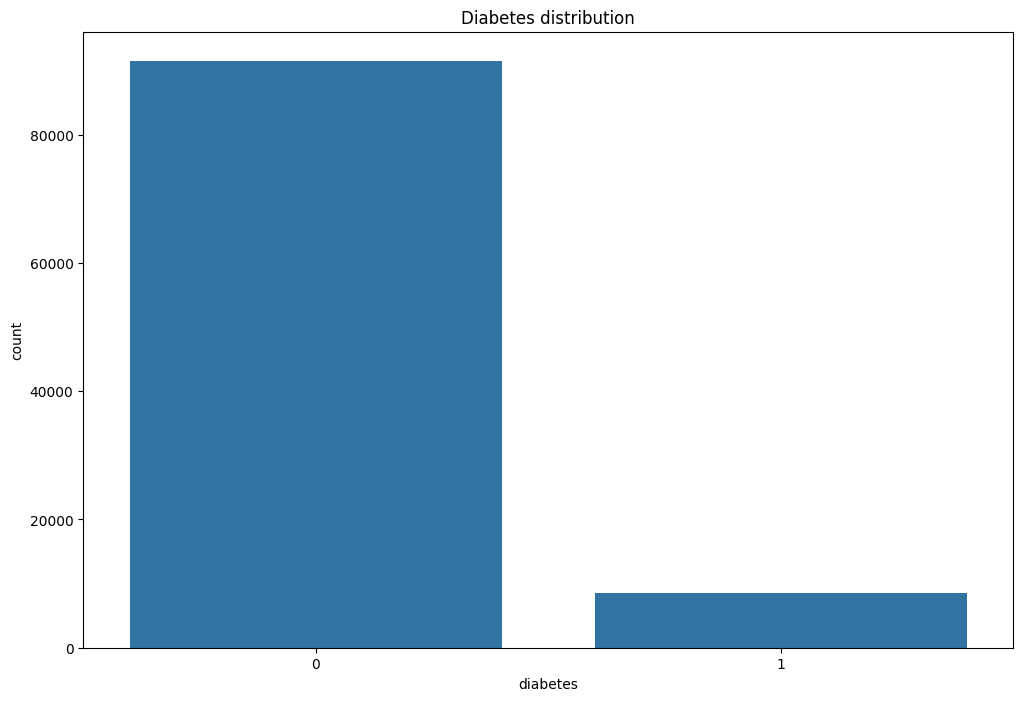

In [255]:
# Visualize distribution for diabetes
df = pd.DataFrame(dataset)

plt.figure(figsize=(12, 8))

sns.countplot(x='diabetes', data=df)
plt.title('Diabetes distribution')
plt.show()

So as we can see here, the target variable is very imbalanced with almost all cases not having diabetes. This may affect the performance of the machine learning models, especially when predicting the minority class, the classifiers will be biased towards the majority class (negative cases). Usually in this case, tools like undersampling or oversampling could be used to mitigate this. (Professor Turcotte mentioned he tried using these techniques however and they didn't quite work).

#### 4. Data Splitting
Here I will split the data before preprocessing to avoid any data leakage.

In [256]:
# Assign values X and y
X = df.drop(columns="diabetes") # Includes every column except the target variable

y = df["diabetes"] # Target column

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

So I have split the data, random state = 42 ensures that the split is reproducible every time the code is run, and stratify=y helps keep the same distribution of the target variable in both training and test sets, which is important when the dataset is imbalanced like ours is.

#### 5. Categorical Variable Encoding
Here I will encode the categorical variables.

In [257]:
# Encoding categorical variables
categorical_cols = ['gender', 'smoking_history']

encoder = OneHotEncoder(sparse_output=False)

# Encode training data
encoded_train_data = encoder.fit_transform(X_train[categorical_cols])

encoded_train_df = pd.DataFrame(encoded_train_data, columns=encoder.get_feature_names_out(categorical_cols), index=X_train.index)

X_train = pd.concat([X_train.drop(columns=categorical_cols), encoded_train_df], axis=1)

# Encode test data
encoded_test_data = encoder.transform(X_test[categorical_cols])

encoded_test_df = pd.DataFrame(encoded_test_data, columns=encoder.get_feature_names_out(categorical_cols), index=X_test.index)

X_test = pd.concat([X_test.drop(columns=categorical_cols), encoded_test_df], axis=1)

My categorical columns here are gender, smoking history, heart disease, and hypertension. Heart disease and hypertension are already encoded as 1s and 0s, so I did not need to apply any transformations to those columns since they will already work with machine learning models. For gender and smoking history, I decided to use one hot encoding because it's useful when building pipelines for preprocessing data before feeding into machine learning models. It also gives more flexibility. index=X_train.index and index=X_test.index make sure that the indices of the encoded data match the original data so that no extra rows are added. I made sure to use fit transform on the training set and only transform on the test set this way the transformer learns the necessary parameters (e.g., mean and standard deviation for scaling) solely from the training data and by only using transform on the test data, I will prevent the model from being influenced by any information from the test set.

#### 6. Transforming Numerical Features
Here I will apply transformations to the numerical features.

In [258]:
# Scale numerical features
numeric_features = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']

scaler = StandardScaler()

# Fit only on the training data and transform the training set
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])

# Apply the same transformation on the test set (without refitting)
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

Here I applied a standard scaler to my numerical attributes because it standardizes the numerical variables by centering them around 0 with a standard deviation of 1. This will help when dealing with features that are on different scales like the ones I'm dealing with here, ensuring that no feature dominates the model simply because of its scale. A lot of algorithms perform better when data is normalized this way. I again made sure to use fit transform for my training data but only transform for my test data.

#### 7. Model Development
Here I will implement machine learning models with default parameters.

In [259]:
# Implementing models
dt_model = DecisionTreeClassifier(random_state=42)
knn_model = KNeighborsClassifier()
lr_model = LogisticRegression(random_state=42, max_iter=1000)

# Training decision tree
dt_model.fit(X_train, y_train)
dt_preds = dt_model.predict(X_test)

# Training KNN
knn_model.fit(X_train, y_train)
knn_preds = knn_model.predict(X_test)

# Training logistic regression
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)

So I implemented the three models seen in class. I used the default parameters of random state = 42 to ensure reproducibility of the results, I also used a max iterations of 1000 for logistic regression to ensure convergence. I will now evaluate these models and see how I can tune the parameters to improve the results.

#### 8. Model Evaluation
Here I will evaluate how my models performed using different metrics.

In [260]:
# Evaluate the models
models = {
    'Decision Tree': dt_model,
    'K-Nearest Neighbors': knn_model,
    'Logistic Regression': lr_model
}

# Number of folds for cross-validation
n_folds = 5

# Evaluate each model using cross-validation
for name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=n_folds, scoring='f1')
    print(f"{name} - Cross-Validation F1 Scores: {cv_scores}")
    print(f"{name} - Mean F1 Score: {cv_scores.mean():.4f}")

    # Fit the model and make predictions for classification report
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    # Print classification report
    print(f"\n{name} Classification Report:\n", classification_report(y_test, preds))

Decision Tree - Cross-Validation F1 Scores: [0.72467903 0.71521269 0.71934215 0.71387491 0.71125494]
Decision Tree - Mean F1 Score: 0.7169

Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97     18300
           1       0.70      0.74      0.72      1700

    accuracy                           0.95     20000
   macro avg       0.84      0.85      0.85     20000
weighted avg       0.95      0.95      0.95     20000

K-Nearest Neighbors - Cross-Validation F1 Scores: [0.74312715 0.729718   0.71558049 0.72315883 0.71636524]
K-Nearest Neighbors - Mean F1 Score: 0.7256

K-Nearest Neighbors Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98     18300
           1       0.88      0.62      0.73      1700

    accuracy                           0.96     20000
   macro avg       0.92      0.80      0.85     20000
weighted avg       0.96    

So here I evaluate my models, I use cross validation and see the F1 score using 5 folds. I chose 5 because it's a good balance that should make sure the model generalizes well without too much overhead, with 2-3 folds, the variance of the performance estimate might be higher, with more folds like 10, the bias might be reduced, but the cost is higher. I used F1 so that it balances precision and recall. I then generate a classification report which, after training each model, generates predictions for the test set and shows a report with the precision, recall and F1 score for each class. </br>
For the results, the decision tree had an average F1 score of 0.7169 which is fairly good considering it used default parameters, it had very high precision and recall scores for the negative class, but slightly poorer results for the positive class which was to be expected given that there were far fewer examples from the positive class. KNN had a mean F1 score of 0.7256 which is a slight improvement, and similar issues with the classification for the negative class vs positive class, but with a slightly higher overall accuracy score. Logistic regression slightly outperformed both, with a mean F1 score of 0.7282, similar issues with the classification but an overall accuracy score of 96%. </br>
So now I will try and tune the parameters to improve on these results.

#### 9. Exploration and Performance Evaluation
Here I will look at the impact of varying hyperparameters on the performance of each model.

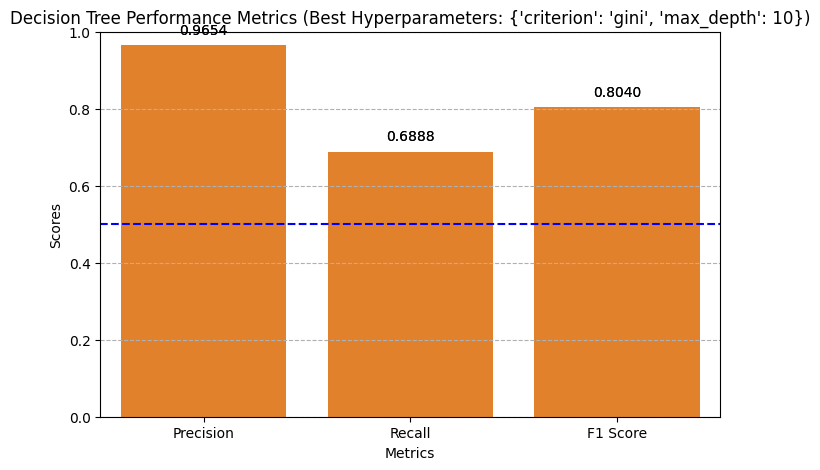

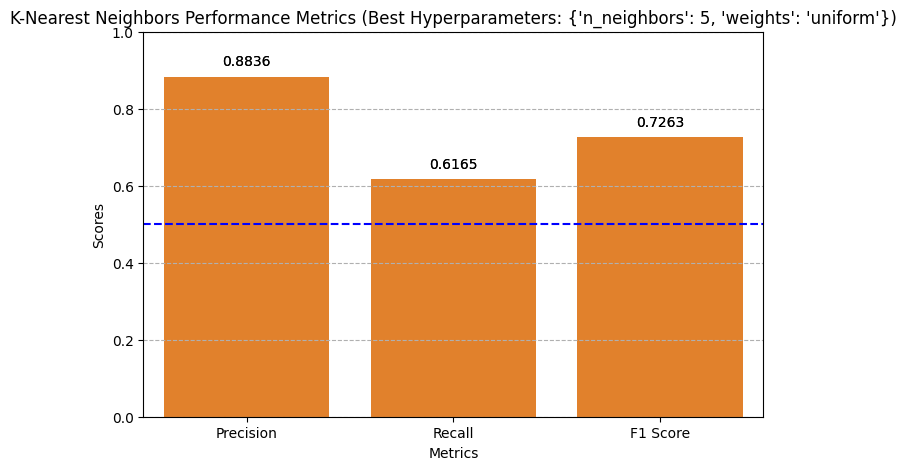

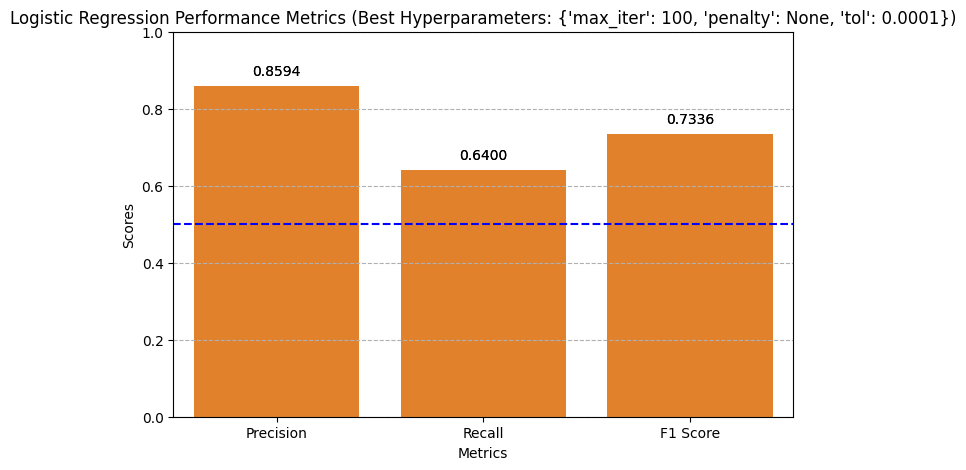

In [261]:
# Test hyperparameters

param_grids = {
    'Decision Tree': {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 5, 10, 15, 20]
    },
    'Logistic Regression': {
        'penalty': ['l2', None],
        'max_iter': [100, 200, 300],
        'tol': [1e-4, 1e-3, 1e-2]
    },
    'K-Nearest Neighbors': {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance']
    }
}

# Dictionary to store the best performance metrics
best_performance_results = []

# Perform grid search for each model
for name, model in models.items():
    grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='f1', return_train_score=False)
    grid_search.fit(X_train, y_train)
    
    # Get the best estimator for the model
    best_estimator = grid_search.best_estimator_
    
    # Predict on the test set
    preds = best_estimator.predict(X_test)
    
    # Calculate precision, recall, and F1 score
    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)

    # Store the best performance metrics
    best_performance_results.append({
        'Model': name,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Best Hyperparameters': grid_search.best_params_
    })

# Create a DataFrame from the best performance results
best_performance_df = pd.DataFrame(best_performance_results)

# Set the number of models
models_count = len(best_performance_df)

# Create bar plots for each model
for index in range(models_count):
    model_name = best_performance_df.loc[index, 'Model']
    metrics = best_performance_df.loc[index, ['Precision', 'Recall', 'F1 Score']]

    plt.figure(figsize=(8, 5))
    bars = sns.barplot(x=metrics.index, y=metrics.values)
    sns.barplot(x=metrics.index, y=metrics.values)
    plt.title(f'{model_name} Performance Metrics (Best Hyperparameters: {best_performance_df.loc[index, "Best Hyperparameters"]})')
    plt.xlabel('Metrics')
    plt.ylabel('Scores')
    plt.ylim(0, 1)  
    plt.axhline(y=0.5, color='blue', linestyle='--')  
    plt.grid(axis='y', linestyle='--')
    for bar in bars.patches:
        plt.text(
            bar.get_x() + bar.get_width() / 2, 
            bar.get_height() + 0.02, 
            f'{bar.get_height():.4f}',  
            ha='center',  
            va='bottom' 
        )
    plt.show()
